* 이륙, 착륙 항공기, 안움직이는 항공기를 나누어야 함 
* A-CDM 파일로 기종 등 정보 가져오기
* metar에서 pressure 가져오기 -> Wheel On/Off의 기준이 되는 altitude 찾게하기
* wheel on/off 지점 지도에 찍기??

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta
import re
import math

In [3]:
# options
pd.set_option('max_columns',100)
warnings.simplefilter('ignore')

# 내꺼

In [ ]:
# initialize
absolute_difference = lambda datalist : abs(datalist - pressure_altitude)

to = pd.DataFrame()
ld = pd.DataFrame()
others = pd.DataFrame()

In [ ]:
# load data
daterange = pd.date_range(start='12/21/2019 15:00', end='12/28/2019 14:00', freq='1H').strftime('%Y%m%d_%H%M%S')
date = daterange[0]
print(date)
df = pd.read_csv(f'../input/MLAT/tp1_{date}_Cat20.ast_Mlat.csv', index_col=False, header = 1)

# 여기서 date를 concat하면 같은 c/s인 항공기가 있어서 안 좋을 것 같음 -> 가장 큰 for loop으로 쓰기
# for date in daterange:
#    df = pd.read_csv(f'../input/tp1_{i}_Cat20.ast_Mlat.csv', index_col=False, header = 1)

In [ ]:
# calculate pressure altitude
current_pressure = float(input('Current pressure : '))
fe_m = 7
msl_ft = 145366.45 * (1 - (current_pressure/1013.25)**0.190284)
msl_m = msl_ft * 0.3048
pressure_altitude = msl_m + fe_m
print('RKSI Field Elevation : 7 m')
print(f'Pressure Altitude : {pressure_altitude} m')

In [ ]:
# Wheel On/Off 지점 찾기

ident = np.unique(df['ModeSIdent'].values).tolist()


for i in ident:
    # c/s별로 wheel on/off 지점인 데이터만 넣기
    temp_df = df[df['ModeSIdent'] == i]
    temp_df['BAlt'] = temp_df['BAlt'].replace('----', 10000).astype(float)         # '----'값은 의미없도록 10000으로 바꿈
    temp_altitude_list = temp_df['BAlt']
    temp_closest_value = min(temp_altitude_list, key = absolute_difference)        # absolute_difference 으로 가장 가까운 값 찾기
    temp_df = temp_df[temp_df['BAlt'] == temp_closest_value]
    
    # ops로 arr / dep나누기
    if temp_df['GroudSpeed'].iloc[0] < temp_df['GroudSpeed'].iloc[-1]:
        temp_df['ops'] = 'departure'
    elif temp_df['GroudSpeed'].iloc[0] > temp_df['GroudSpeed'].iloc[-1]:
        temp_df['ops'] = 'arrival'
    else:
        temp_df['ops'] = 'others'
    
    # arr / dep 각각 저장 - # landing은 0, takeoff는 -1로 해야함
    if abs(temp_df['BAlt'].iloc[0] - pressure_altitude) > 100:    # 너무 큰 이상한 것은 버림
        others = others.append(temp_df)
    elif (temp_df['ops'].iloc[0] == 'departure') & (temp_df['GroudSpeed'].iloc[-1] > 50):    
        to = to.append(temp_df.iloc[-1,:])    
    elif (temp_df['ops'].iloc[0] == 'arrival') & (temp_df['GroudSpeed'].iloc[0] > 50):
        ld = ld.append(temp_df.iloc[0,:])
    else:
        others = others.append(temp_df)

In [ ]:
base_map = plt.imread('../data/map.png')
BBox = (126.3940, 126.4743, 37.4414, 37.4856)

fig, ax = plt.subplots(figsize = (25,20))
ax.scatter(to['Longitude'], to['Latitude'], alpha= 0.6, c='b', s=15, marker = 'o')
ax.scatter(ld['Longitude'], ld['Latitude'], alpha= 0.6, c='r', s=15, marker = 'x')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(base_map, zorder = 0, extent = BBox, aspect= 'equal')

In [ ]:
to

# 교수님 데이터

% plot1 Northflow
figure;
geoplot(rwyThrLat, rwyThrLon, 'gd');
hold on;
for i=1:3
    indOnRwy = find(onRwy==i);  % Arrival on runway i
    if ~isempty(indOnRwy)
        geoplot(onLat(indOnRwy), onLon(indOnRwy), 'r*');
    end
    indOffRwy = find(offRwy==i);    % Departure on runway i
    if ~isempty(indOffRwy)
        geoplot(offLat(indOffRwy), offLon(indOffRwy), 'b*');
    end
end
title('North flow');
legend('RWY Threshold', 'Arrival', 'Departure');



% plot2 Southflow
figure;
geoplot(rwyThrLat, rwyThrLon, 'gd');
hold on;
for i=4:6
    indOnRwy = find(onRwy==i);  % Arrival on runway i
    if ~isempty(indOnRwy)
        geoplot(onLat(indOnRwy), onLon(indOnRwy), 'r*');
    end
    indOffRwy = find(offRwy==i);    % Departure on runway i
    if ~isempty(indOffRwy)
        geoplot(offLat(indOffRwy), offLon(indOffRwy), 'b*');
    end
end
title('South flow');
legend('RWY Threshold', 'Arrival', 'Departure');



% plot others...
for i=1:6
    indOnRwy = find(onRwy==i);  % Arrival on runway i
    if ~isempty(indOnRwy)
        figure;
        histogram(onDist(indOnRwy), floor(min(onDist(indOnRwy))):1:ceil(max(onDist(indOnRwy))));
        title(['On distance (m) from ', rwyName{i}, ' threshold']);
    end
    indOffRwy = find(offRwy==i);    % Departure on runway i
    if ~isempty(indOffRwy)
        figure;
        histogram(offDist(indOffRwy), floor(min(offDist(indOffRwy))):1:ceil(max(offDist(indOffRwy))));
        title(['Off distance (m) from ', rwyName{i}, ' threshold']);
    end
end

In [25]:
columns = ['Time', 'Callsign', 'AC', 'Lat', 'Lon', 'RWY', 'DIST']

In [26]:
arr_df = pd.read_csv(f'../input/arr_data.csv', index_col=False, header = 0)
dep_df = pd.read_csv(f'../input/dep_data.csv', index_col=False, header = 0)

In [27]:
arr_df.columns = columns
dep_df.columns = columns

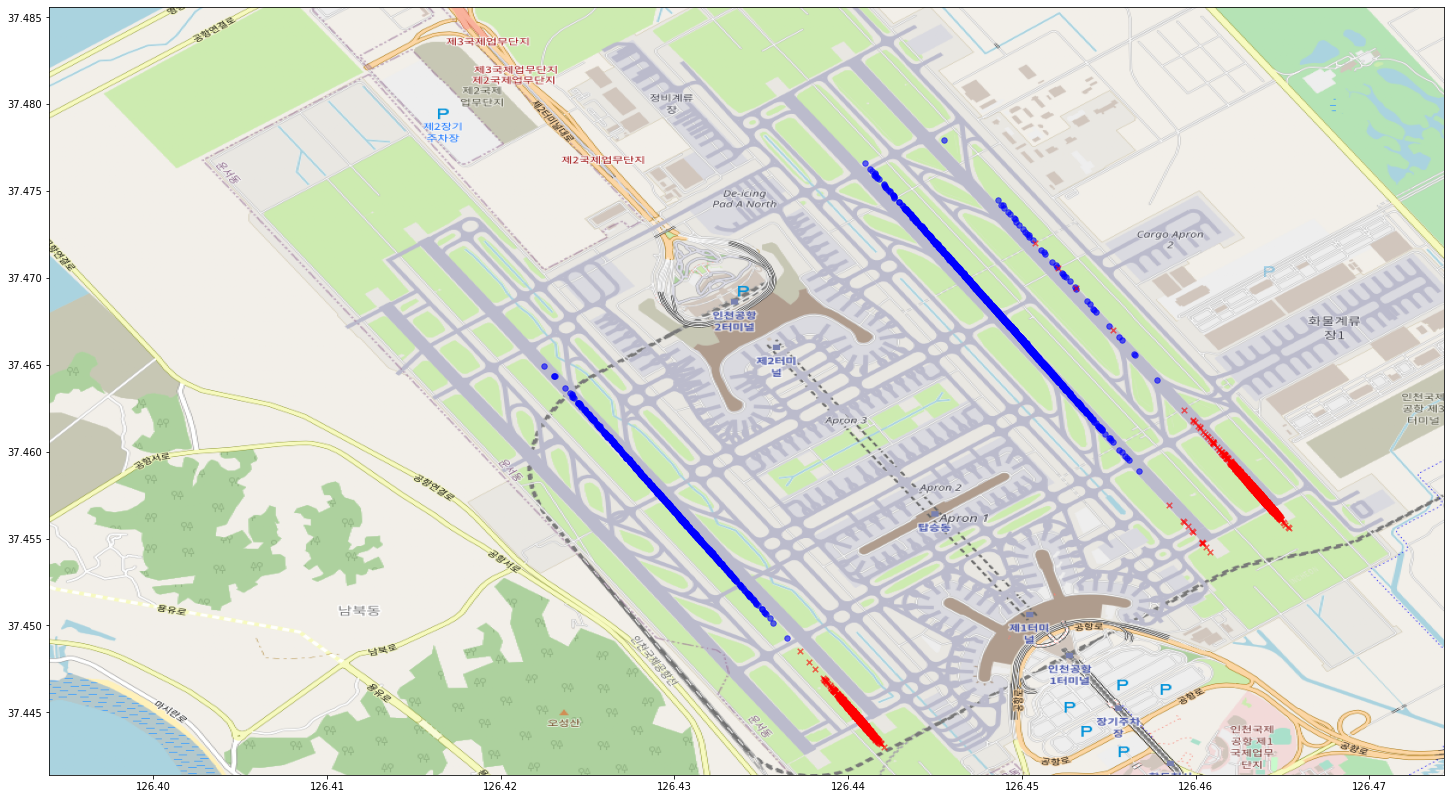

In [47]:
# North flow

# 1-3 : Northflow / 4-6 : Southflow

base_map = plt.imread('../data/map.png')
BBox = (126.3940, 126.4743, 37.4414, 37.4856)

arr_df_north = arr_df[arr_df['RWY'] <= 3]
dep_df_north = dep_df[dep_df['RWY'] <= 3]

fig, ax = plt.subplots(figsize = (25,20))
ax.scatter(dep_df_north['Lon'], dep_df_north['Lat'], alpha= 0.6, c='b', s=30, marker = 'o')
ax.scatter(arr_df_north['Lon'], arr_df_north['Lat'], alpha= 0.6, c='r', s=30, marker = 'x')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(base_map, zorder = 0, extent = BBox, aspect= 'equal')

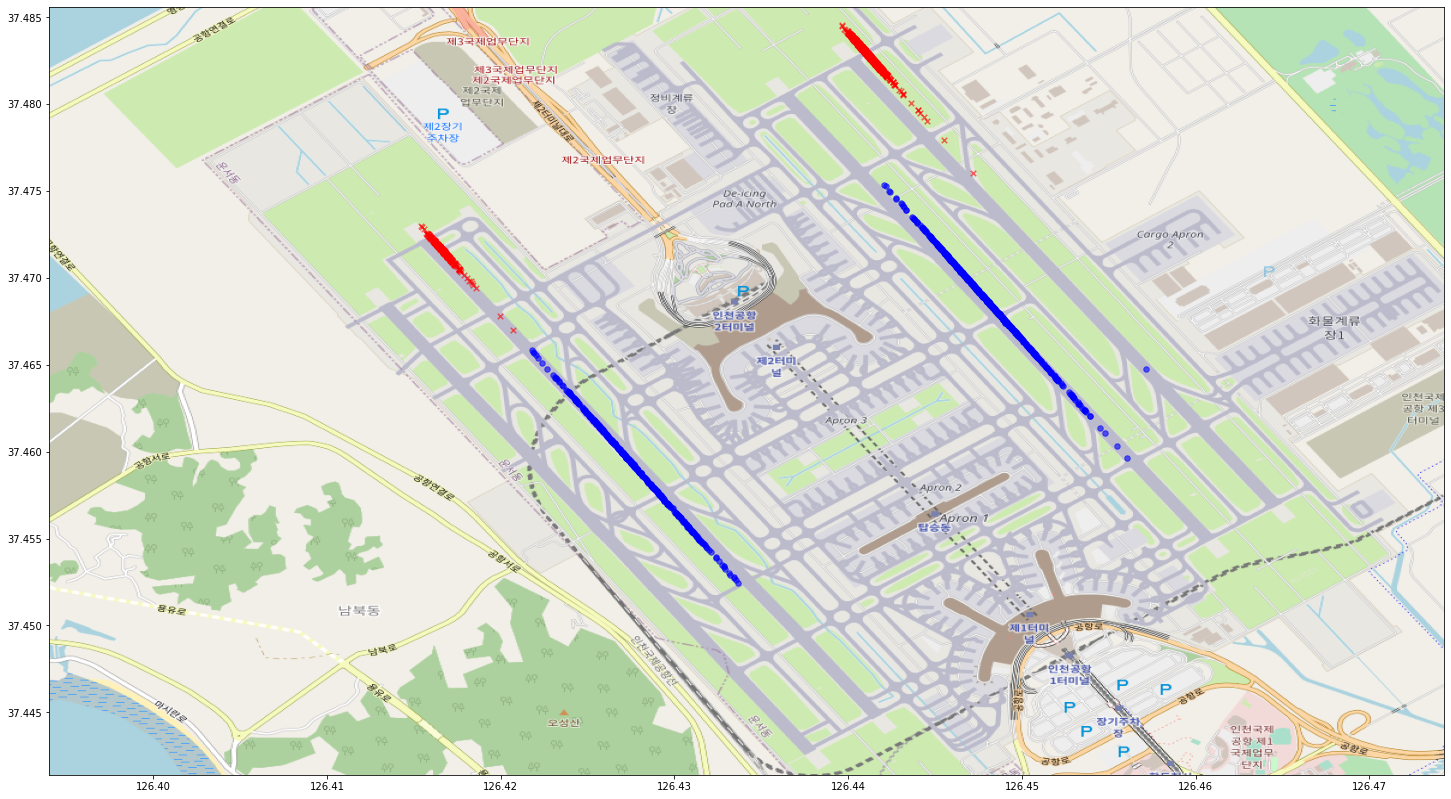

In [48]:
# South flow

base_map = plt.imread('../data/map.png')
BBox = (126.3940, 126.4743, 37.4414, 37.4856)

arr_df_south = arr_df[arr_df['RWY'] > 3]
dep_df_south = dep_df[dep_df['RWY'] > 3]

fig, ax = plt.subplots(figsize = (25,20))
ax.scatter(dep_df_south['Lon'], dep_df_south['Lat'], alpha= 0.6, c='b', s=30, marker = 'o')
ax.scatter(arr_df_south['Lon'], arr_df_south['Lat'], alpha= 0.6, c='r', s=30, marker = 'x')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(base_map, zorder = 0, extent = BBox, aspect= 'equal')